In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import trange, tqdm

In [2]:
train_data_original = datasets.FashionMNIST(root = "/kaggle/working/", train = True, download = True, transform = None)
test_data_original = datasets.FashionMNIST(root = "/kaggle/working/", train = False, download = True, transform = None)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 307kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.46MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.26MB/s]


In [3]:
len(train_data_original)

60000

In [4]:
X_train = train_data_original.data.numpy().astype(np.float32)/255
y_train = train_data_original.targets.numpy().astype(np.int32)
X_test = test_data_original.data.numpy().astype(np.float32)/255
y_test = test_data_original.targets.numpy().astype(np.int32)

In [5]:
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [6]:
X_train=X_train.reshape(len(X_train),784)
X_test=X_test.reshape(len(X_test),784)

In [7]:
# Normalizing and standardizing the data
X_train = (X_train-X_train.mean())/X_train.std()
X_test = X_test-X_test.mean()/X_test.std()

In [8]:
# MNIST Digit data
X_digits_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
y_digits_train = X_digits_train['label']
X_digits_train = X_digits_train.drop(columns = X_digits_train.columns[0])

In [9]:
y_digits_train.head(), X_digits_train.head()

(0    1
 1    0
 2    1
 3    4
 4    0
 Name: label, dtype: int64,
    pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
 0       0       0       0       0       0       0       0       0       0   
 1       0       0       0       0       0       0       0       0       0   
 2       0       0       0       0       0       0       0       0       0   
 3       0       0       0       0       0       0       0       0       0   
 4       0       0       0       0       0       0       0       0       0   
 
    pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
 0       0  ...         0         0         0         0         0         0   
 1       0  ...         0         0         0         0         0         0   
 2       0  ...         0         0         0         0         0         0   
 3       0  ...         0         0         0         0         0         0   
 4       0  ...         0         0         0         0         0  

In [10]:
X_digit_train = X_digits_train.to_numpy(dtype = np.float32)
y_digit_train = y_digits_train.to_numpy(dtype = np.int32)

In [11]:
X_digit_train = X_digit_train / 255.0
y_digit_train = np.eye(10)[y_digit_train]

In [12]:
y_digit_train.shape

(42000, 10)

In [13]:
rng = np.random.default_rng()
rng.normal((1,50,1)), rng.random(2)

(array([ 1.77282862, 49.88065793,  0.27637433]),
 array([0.26053917, 0.93072733]))

In [14]:
act = rng.random(10)

Mulitplication in Arrays:

1. a(n,m) * b(n,m) = element wise multiplication of a and b
2. a(n,m) * b(m,k) = c(n,k) matrix multiplication
3. a(n,m) * b(m,) = element wise multiplication of a[:][i] by b[i], is reciprocable
4. a(n,m) @ b(m,k) = c(n,k)
5. a(n,m) @ b(m,) = matrix multiplication, a(n,m) X b(m,1)
6. np.outer(a(n,), b(m,)) = outer product(c(n,m))
7. np.dot(a(n,m), b(m,k)) = c(n,k)
8. np.dot(a(n,m), b(m,)) = c(n,)
9. np.dot(a(n,m), b(n,m)) element-wise multiplicaiton

In [35]:
class Network_MLP():
    def __init__(self, network_dims):
        rndg = np.random.default_rng(21)
        self.num_layers = len(network_dims)
        self.netwrok_dims = network_dims
        self.weights = [rndg.normal(loc = 0.0, size = (n,m), scale = np.sqrt(1.0/(m))) for m,n in zip(network_dims[:-1], network_dims[1:])]      
        self.biases = [np.zeros((b,)) for b in network_dims[1:]]

    def softmax(self, z):
        z_shift = z-np.max(z)
        e = np.exp(z_shift)
        return e/np.sum(e)

    def relu(self, z):
        return np.maximum(0,z)

    def relu_prime(self, z):
        return (z > 0).astype(np.float32)
    
    def sigmoid(self, z):
        sig = []
        for i in z:
            temp = 1.0/(1.0+np.exp(-i))
            sig.append(temp)
        return np.array(sig)
    
    def sigmoid_prime(self, z):
        sig = []
        for i in z:
            temp = (np.exp(-i))/np.power((1.0+np.exp(-i)),2)
            sig.append(temp)
        sig = np.array(sig)
        return sig

    def feedforward(self, a):
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            a = self.relu((w @ a) + b)
        a = self.softmax(self.weights[-1] @ a + self.biases[-1])
        return a

    # def forward(self, x, y):
    #     delta_w, delta_b = self.backprop(x[0][:8], y[0])
    #     return delta_w, delta_b 


    def backprop(self, x, y, t):
        # if (t < 2 or t > 5997):
        #     print(f"In Backprop, Train Instance: {t}")
        delta_weights = [np.zeros(w.shape) for w in self.weights]
        delta_biases = [np.zeros(b.shape) for b in self.biases]
        activation = x
        activations = [activation]
        zs = []
        layer_num = 1
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            z = (w @ activation) + b
            # if (t < 2 or t > 5997):
            #     print(f"  layer : {layer_num}====> max: {np.max(z)} | min : {np.min(z)}")
            # #     # print(f"      sigmoid - {t}: {z[:2]} ----> {self.sigmoid(z[:2])}")
            #     layer_num+=1
            zs.append(z)
            activation = self.relu(z)
            activations.append(activation)
        z_final = self.weights[-1] @ activation + self.biases[-1]
        zs.append(z_final)
        activation = self.softmax(z_final)
        activations.append(activation)
        # if (t < 2 or t > 5997):
        #         print(f"  layer : {layer_num}====> max: {np.max(z_final)} | min : {np.min(z_final)}")
        #         print(f"      softmax - {t}: {z_final[:2]} ----> {self.softmax(z_final)[:2]}")
        #         layer_num+=1
        
            
        # delta_L = (activations[-1] - y) * self.sigmoid_prime(zs[-1])
        delta_L = activations[-1] - y
        delta_biases[-1] = delta_L
        delta_weights[-1] = np.outer(delta_L, activations[-2])  # (n,) X (m,) = (n,m)  n=2, m=3
        for i in range(2, self.num_layers):
            delta = (self.weights[1-i].transpose() @ delta_L) * (self.relu_prime(zs[-i]))
            delta_biases[-i] = delta
            delta_weights[-i] = np.outer(delta ,activations[-i-1])
            delta_L = delta
        return delta_weights, delta_biases

    def evaluate_test (self , test_data, test_label):
        labels_map={
            0: 'T-shirt',
            1: 'Trouser',
            2: 'Pullover',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle Boot',
        }
        test_results_index = [(np.argmax(self.feedforward(x.reshape(784,)))) for x in test_data]
        # test_results = [(self.feedforward(x.reshape(784,)), np.argmax(self.feedforward(x.reshape(784,)))) for x in test_data]
        true_labels = [(np.argmax([i])) for i in test_label]
        # print(f"Pred labels: {test_results_index}")
        # print(f"True labels: {true_labels}")
        incorrect_idxes = [i for i, (pred, true) in enumerate(zip(test_results_index, true_labels)) if pred!=true]
        n_wrong = len(incorrect_idxes)
        print(f"Correct: {len(test_data)-n_wrong} / {len(test_data)}")
        return len(test_data)-n_wrong
    
    def evaluate (self , test_data, test_label):
        labels_map={
            0: 'T-shirt',
            1: 'Trouser',
            2: 'Pullover',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle Boot',
        }
        test_results_index = [(np.argmax(self.feedforward(x.reshape(784,)))) for x in test_data]
        # test_results = [(self.feedforward(x.reshape(784,)), np.argmax(self.feedforward(x.reshape(784,)))) for x in test_data]
        true_labels = [(np.argmax([i])) for i in test_label]
        print(f"Pred labels: {test_results_index}")
        print(f"True labels: {true_labels}")
        incorrect_idxes = [i for i, (pred, true) in enumerate(zip(test_results_index, true_labels)) if pred!=true]
        n_wrong = len(incorrect_idxes)
        fig = plt.figure(figsize = (2.5*n_wrong,10))
        
        for plot_i, idx in enumerate(incorrect_idxes, start = 1):
            image, label = test_data_original[idx]
            ax = fig.add_subplot(1,n_wrong,plot_i)
            plt.title(f"T: {labels_map[label]}  F: {labels_map[test_results_index[idx]]}")
            ax.imshow(image, cmap = 'gray')
            ax.axis('off')
        plt.show()
        return len(test_data)-n_wrong
        # return None
        
    def SGD(self , training_data, training_labels, epochs , mini_batch_size , et , decay,  test_data = None , test_label = None):
        if test_data.any():
            n_test = len(test_data)
            n = len(training_data)
        eta0    = et    # initial LR
        gamma   = decay    # decay factor
        step_T  = 5
        for j in range(epochs):#, desc = "Epochs", unit = "ep", leave= True):
            eta = eta0 * (gamma ** (j // step_T))
            print(f"Epoch : {j+1}/{epochs}")
            t=0
            n_batches = (n + mini_batch_size - 1) // mini_batch_size
            with tqdm(total=n_batches,
                             desc="Batches",
                             unit="batch",
                             leave=False) as batch_bar:
                
                for k in range(0, n, mini_batch_size):
                    batch_X = training_data[k : k + mini_batch_size]
                    batch_y = training_labels[k : k + mini_batch_size]
                    t = self.update_mini_batch(batch_X, batch_y, eta, t)
                    batch_bar.update(1)
            # self.update_mini_batch(training_data, training_labels , eta)
            if test_data.any() :
                print("Correct: {1} / {2}". format(j+1, self.evaluate_test(test_data, test_label), n_test))
            else :
                print("Epoch {0} complete ". format(j+1))

    def update_mini_batch(self, training_data, training_labels , eta, t):
        delta_biases = [np.zeros (b.shape) for b in self.biases ]
        delta_weights = [np.zeros (w.shape) for w in self.weights ]
        for x, y in zip(training_data, training_labels) :
            delta_nabla_w , delta_nabla_b = self.backprop (x, y, t)
            t+=1
            delta_biases = [nb+dnb for nb , dnb in zip(delta_biases ,delta_nabla_b)]
            delta_weights = [nw+dnw for nw , dnw in zip(delta_weights ,delta_nabla_w)]
        # if (t<2 or t>5998):
            # print(f"last bias : {delta_biases[-1][0]}\n")
        self.weights = [w -(eta/len(training_data))*nw for w, nw in zip(self.weights, delta_weights)]
        self.biases = [b -(eta/len(training_data))*nb for b, nb in zip(self.biases, delta_biases)]
        return t

Pred labels: [0, 9, 0, 0, 0]
True labels: [9, 2, 1, 1, 6]


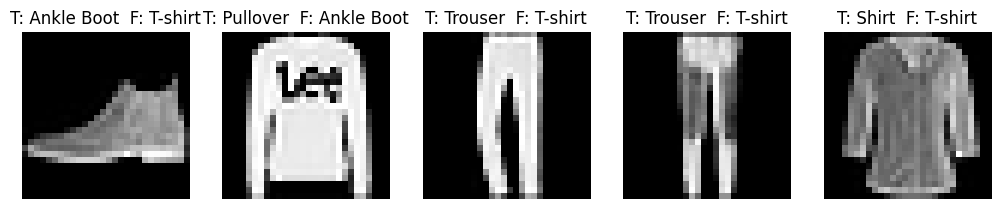

0

In [36]:
model_1 = Network_MLP(network_dims = [784,89,10])
model_1.evaluate(X_test[0:5],y_test[0:5])

In [37]:
model_1 = Network_MLP(network_dims = [784,30,10])
# len(model_1.biases)
model_1.SGD(X_train, y_train, 25, 100, 0.30, 0.8, X_test[0:50],y_test[0:50])
# model_1.SGD(X_digit_train[:40000], y_digit_train[:40000], 20, 200, 0.05, X_digit_train[40000:40015],y_digit_train[40000:40015])

Epoch : 1/25


Correct: 33 / 50
Correct: 33 / 50
Epoch : 2/25


Correct: 31 / 50
Correct: 31 / 50
Epoch : 3/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 4/25


Correct: 37 / 50
Correct: 37 / 50
Epoch : 5/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 6/25


Correct: 36 / 50
Correct: 36 / 50
Epoch : 7/25


Correct: 36 / 50
Correct: 36 / 50
Epoch : 8/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 9/25


Correct: 36 / 50
Correct: 36 / 50
Epoch : 10/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 11/25


Correct: 34 / 50
Correct: 34 / 50
Epoch : 12/25


Correct: 36 / 50
Correct: 36 / 50
Epoch : 13/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 14/25


Correct: 36 / 50
Correct: 36 / 50
Epoch : 15/25


Correct: 36 / 50
Correct: 36 / 50
Epoch : 16/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 17/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 18/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 19/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 20/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 21/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 22/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 23/25


Correct: 35 / 50
Correct: 35 / 50
Epoch : 24/25


Correct: 34 / 50
Correct: 34 / 50
Epoch : 25/25


Correct: 35 / 50
Correct: 35 / 50


In [34]:
model_1.evaluate_test(X_test, y_test)

Correct: 6374/ 10000


6374

In [ ]:
model_2 = Network_MLP(network_dims = [784,90,10])
model_2.SGD(X_train, y_train, 25, 200, 0.30, X_test[0:25],y_test[0:25])

In [ ]:
model_2.evaluate_test(X_test, y_test)

In [ ]:
model_3 = Network_MLP(network_dims = [784,90,10])
model_3.SGD(X_train, y_train, 40, 200, 0.20, X_test[0:25],y_test[0:25])

In [ ]:
model_3.evaluate_test(X_test, y_test)

In [ ]:
model_4 = Network_MLP(network_dims = [784,128,10])
model_4.SGD(X_train, y_train, 40, 200, 0.30, X_test[0:25],y_test[0:25])

In [ ]:
model_4.evaluate_test(X_test, y_test)

In [ ]:
model_5 = Network_MLP(network_dims = [784,128,30,10])
model_5.SGD(X_train, y_train, 25, 100, 0.50, X_test[0:25],y_test[0:25])

In [ ]:
model_5.evaluate_test(X_test, y_test)

In [ ]:
model_6 = Network_MLP(network_dims = [784,90,30,10])
model_6.SGD(X_train, y_train, 25, 100, 0.50, X_test[0:25],y_test[0:25])

In [ ]:
model_6.evaluate_test(X_test, y_test)

In [ ]:
model_7 = Network_MLP(network_dims = [784,256,90,30,10])
model_7.SGD(X_train, y_train, 25, 100, 0.40, X_test[0:25],y_test[0:25])

In [ ]:
model_7.evaluate_test(X_test, y_test)

In [ ]:
model_8 = Network_MLP(network_dims = [784,256,90,10])
model_8.SGD(X_train, y_train, 25, 200, 0.30, X_test[0:25],y_test[0:25])

In [ ]:
model_8.evaluate_test(X_test, y_test)

In [ ]:
model_9 = Network_MLP(network_dims = [784,512,256,90,30,10])
model_9.SGD(X_train, y_train, 25, 100, 0.40, X_test[0:25],y_test[0:25])

In [ ]:
model_9.evaluate_test(X_test, y_test)

In [ ]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

idx = 5999
image, label = train_data_original[idx]
figure = plt.figure(figsize = (10,10))
figure.add_subplot(5,1,1)
plt.title(labels_map[label])
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.show()